In [1]:
# Importando librerías 
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim
from statistics import mode
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics



## 1. Lectura de DataFrame 

In [2]:
data = pd.read_csv(r'propiedades.csv', sep = ',', index_col = 0)
print(f'El dataframe de properati está compuesto por {data.shape[1]} columnas y {data.shape[0]} filas') 
data.sample(3)
data.shape

El dataframe de properati está compuesto por 16 columnas y 107980 filas


(107980, 16)

In [3]:
# Considerando el volumen de datos y espacio geográfico abarcado por las diferentes provincias, 
# se procederá a estudiar la relación y variación de precios en propiedades en Capital Federal y posteriormente en Córdoba

data = data.loc[data['state_name'] == 'Capital Federal']
print(f'El dataframe de properati está compuesto por {data.shape[1]} columnas y {data.shape[0]} filas') 

El dataframe de properati está compuesto por 16 columnas y 31308 filas


## 2. Descripción breve del DataFrame.


El DataFrame en estudio cuenta con 15 columnas y un total de 31308 filas (incluyendo valores nulos) por columna. 

Las columnas contenidas en el DataFrame son: 

2.1 property_Type. Compuesta por datos del tipo string, en la cual se describe el tipo de propiedad. Ejemplo: PH, apartment, etc. 

2.2 place_name. Compuesta por datos del tipo string, en la cual se describe localidad donde está ubicada la propiedad. Ejemplo: Villa Crespo, Belgrano.

2.3 state_name. Compuesta por datos del tipo string, en la cual es informada la provincia en el cual se ubica la propiedad. Ejemplo: Capital Federal.

2.4 surface_total_in_m2. Compuesta por valores del tipo float64, y muestra la superficie total en metros cuadrados (m2) que abarca la propiedad. Ejemplo: 55.0.

2.5 surface_covered_in_m2. Compuesta por valores del tipo float64, y muestra la superficie cubierta en metros cuadrados (m2) dentro de la propiedad. Ejemplo: 40.0.

2.6 'apartment', 'house' y 'store'. Columnas con valores dummies para informar tipo de propiedad. 

2.7 ''amb_2.0', 'amb_3.0', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5', 'amb_No Informado'. Columnas con valores dummies para informar el número de ambientes en la propiedad. 

In [4]:
# Resumen de nombre y tipo de dato por columna

print('\n')
print('-----------Tipo de datos por columna-----------')
print(data.dtypes)



-----------Tipo de datos por columna-----------
property_type             object
place_name                object
state_name                object
price_aprox_usd          float64
surface_total_in_m2      float64
surface_covered_in_m2    float64
price_usd_per_m2         float64
apartment                  int64
house                      int64
store                      int64
amb_2.0                    int64
amb_3.0                    int64
amb_4.0                    int64
amb_5.0                    int64
amb_Mayor a 5              int64
amb_No Informado           int64
dtype: object


## 3. Distribución de los datos.  

<AxesSubplot: >

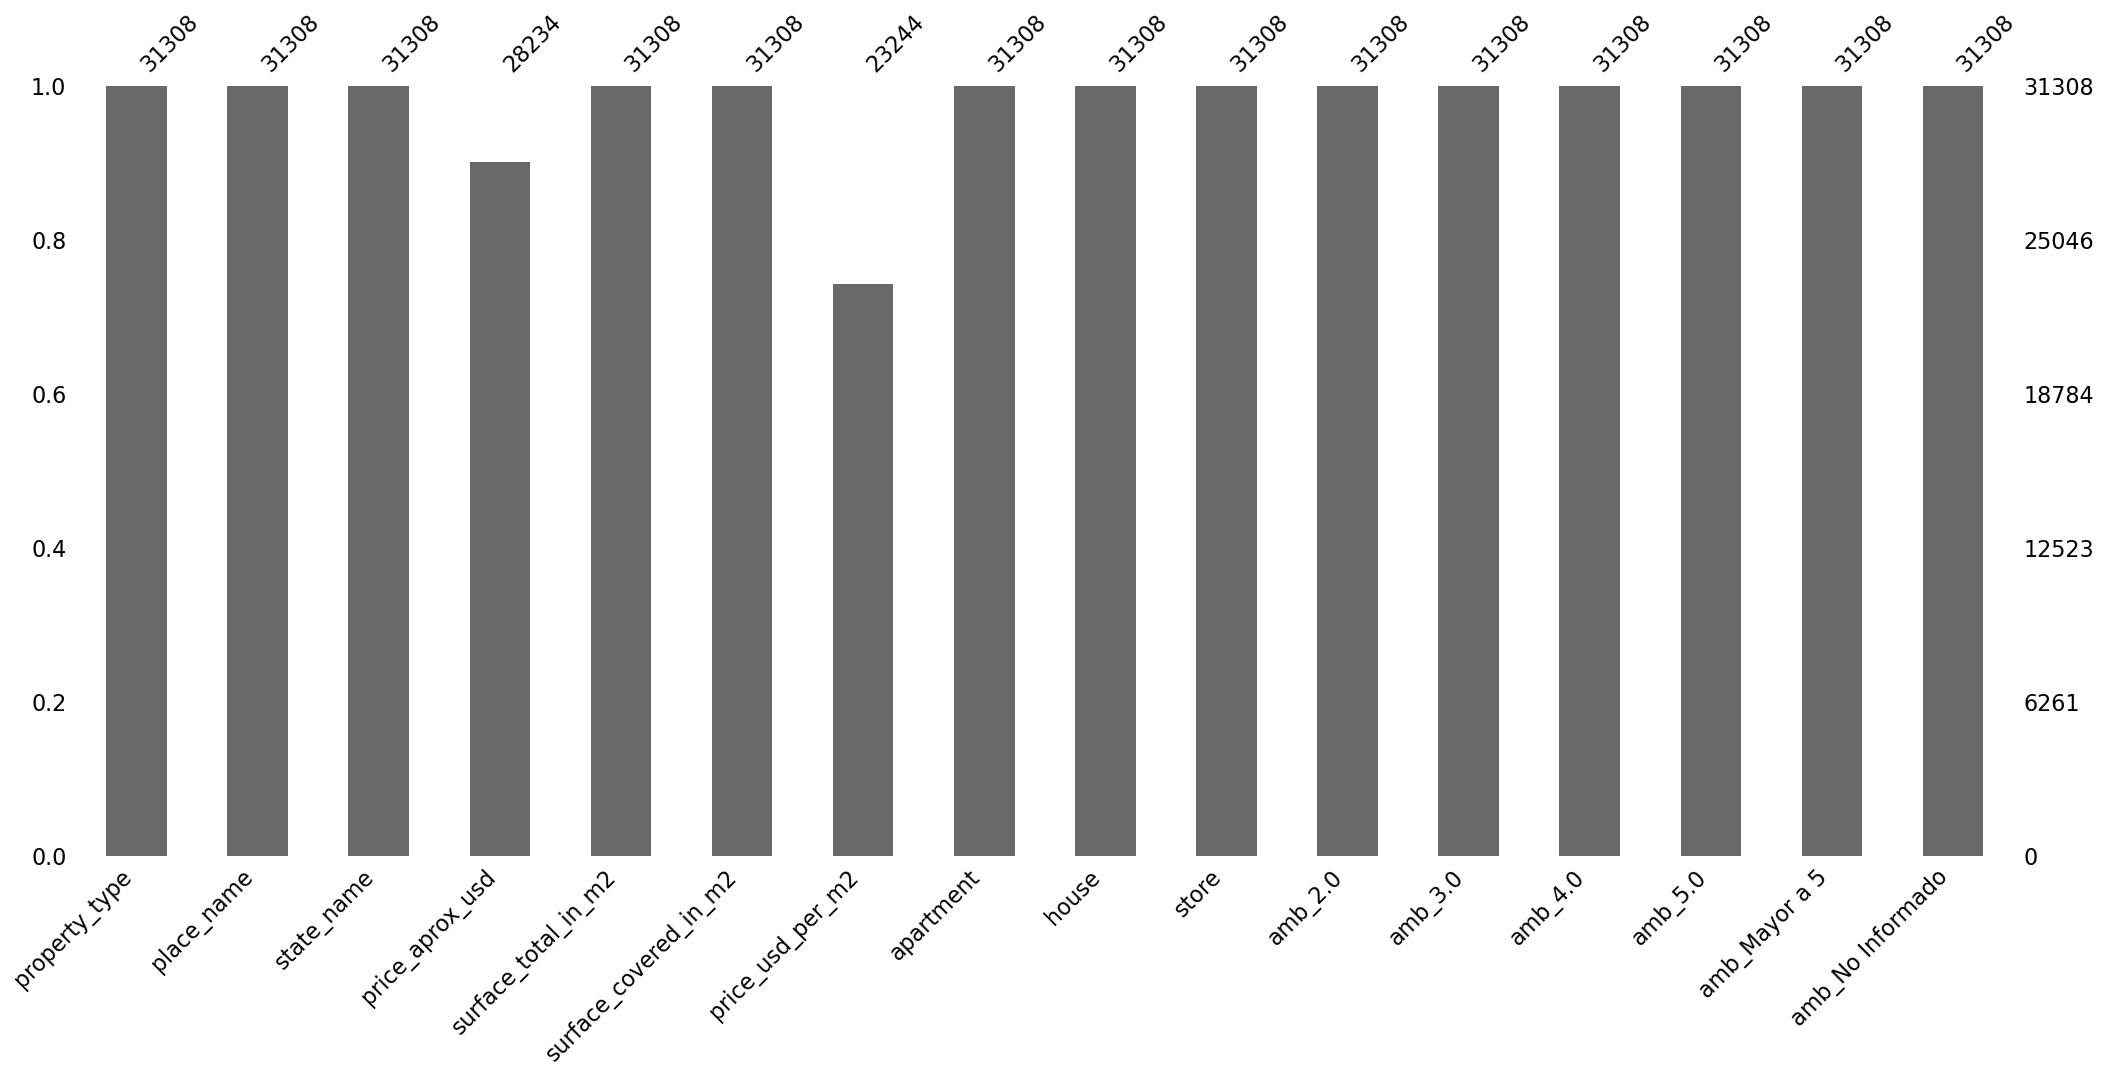

In [5]:
# Para saber valores no nulos

msno.bar(data)

MENCIONAR VARIABILIDAD DE LOS DATOS (HAY QUE COMPLETARLO)

Aproximadamente el 40% de las columnas contienen datos diferentes de NaN dentro de su estructura en el DataFrame. El restante 60% está distribuido de la siguiente manera: 
 - Columnas que contienen entre 50% y 80% de datos completos. (50%)
 - Columnas que contienen por debajo del 40% de datos completos. (10%)

TOMAR DECISIÓN RESPECTO A ¿CUÁL SERÁ NUESTRA VARIABLE TARGET? 

Según el análisis que hicimos para TP1 , propongo tomar como variable target la columna PRICE, QUE TENDRÍAMOS QUE RECUPERAR DEL DATAFRAME PRINCIPAL DE PROPERATTI O EN TAL CASO TOMAR LA COLUMNA PRICE_APROX_USD

## 4. Eliminación de datos.

Eliminar columna que tiene relación con precios y no son nuestra variable target, o ya fueron convertidas en variables dummies 

In [6]:
# data.drop(['price_usd_per_m2', 'property_type'], axis = 1, inplace = True)
data.drop(['price_usd_per_m2'], axis = 1, inplace = True)

Eliminar columnas donde existan valores nulos para la variable a predecir (price_aprox_usd)

In [7]:
data.dropna(axis = 0, subset = ['price_aprox_usd'], inplace = True)

<AxesSubplot: >

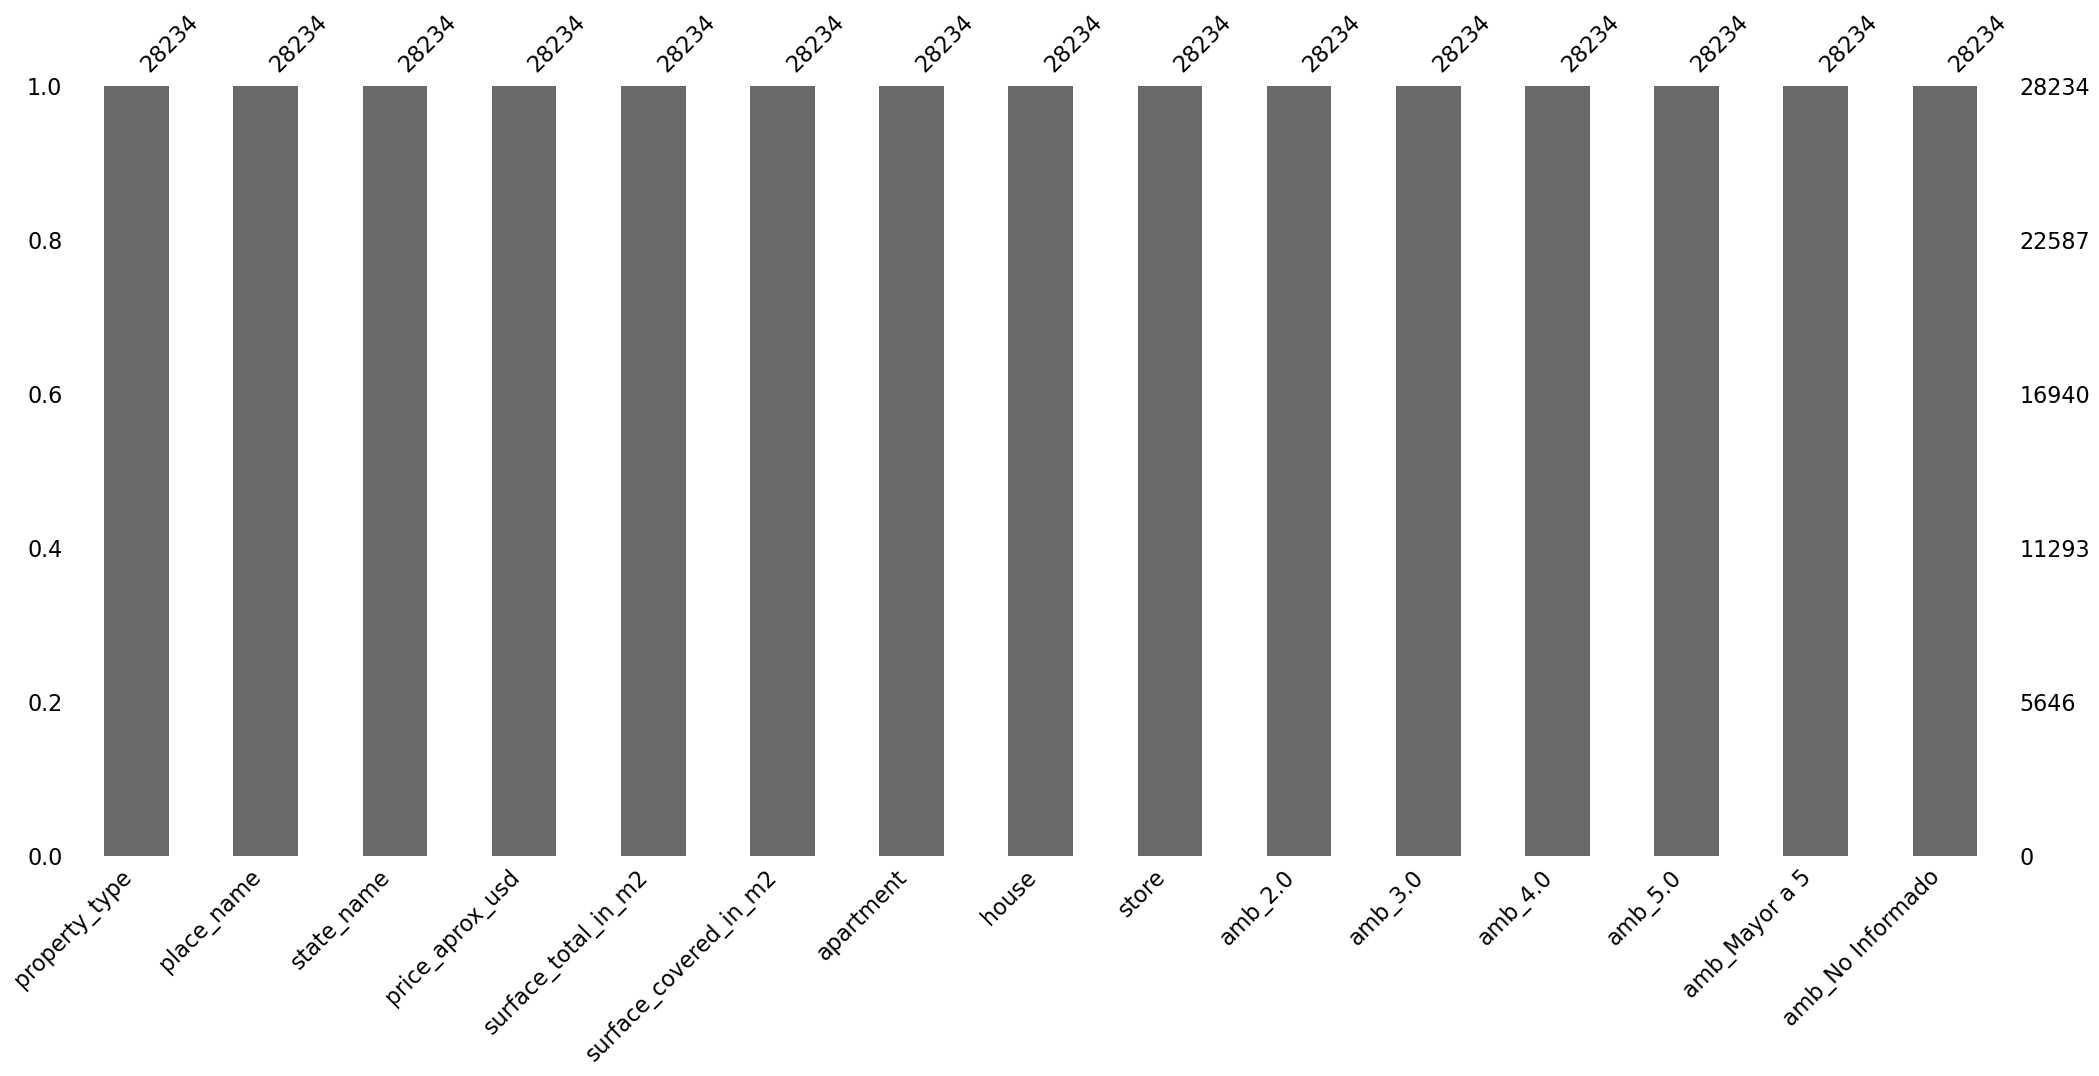

In [8]:
msno.bar(data)

In [9]:
data.sample(3)

,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,apartment,house,store,amb_2.0,amb_3.0,amb_4.0,amb_5.0,amb_Mayor a 5,amb_No Informado
35020,store,Capital Federal,Capital Federal,60000.00,61.501882,35.0,0,0,1,0,0,0,0,0,1
118758,apartment,Villa Urquiza,Capital Federal,102987.29,37.000000,32.0,1,0,0,0,0,0,0,0,1
26457,apartment,Congreso,Capital Federal,36000.00,38.000000,38.0,1,0,0,0,0,0,0,0,0


## 5. Creación de Variables Dummies.

Continuando con el análisis, la propuesta ahora es generar variables dummy para aquellas variables categóricas que podrían aportar información valiosa al momento de clasificar las propiedades.

Analizando el DataFrame , será creado un nuevo grupo de propiedades en el cual estarán agrupadas todas aquellos Barrios dentro de Capital Federal que posean un número de propiedades menor o igual a 100.

In [10]:
place_group = (data.groupby(['place_name'])['place_name'].count()).sort_values(ascending=False)
display(place_group)

place_name
Belgrano           2516
Palermo            2473
Caballito          2031
Recoleta           1403
Villa Urquiza      1350
                   ... 
Agronomía            37
Velez Sarsfield      34
Villa Soldati        15
Villa Riachuelo       5
Catalinas             2
Name: place_name, Length: 62, dtype: int64

In [11]:
# Convertimos a DataFrame
place = pd.DataFrame(place_group)
place.index.name = None

# Generamos nuevo DataFrame con Barrios dentro de Capital Federal con 500 propiedades o menos 
pocas_propiedades = place[place['place_name'] <= 500]

pocas_prop = pocas_propiedades.index
pocas_prop

Index(['Palermo Hollywood', 'Villa del Parque', 'San Cristobal', 'Floresta',
       'Barracas', 'Villa Devoto', 'Mataderos', 'Villa Luro', 'Colegiales',
       'Palermo Soho', 'Liniers', 'Parque Patricios', 'Congreso', 'Coghlan',
       'Retiro', 'Centro / Microcentro', 'Chacarita', 'Boca', 'Constitución',
       'Palermo Chico', 'Villa Lugano', 'Villa Pueyrredón', 'San Nicolás',
       'Paternal', 'Once', 'Parque Chacabuco', 'Las Cañitas', 'Abasto',
       'Tribunales', 'Villa Ortuzar', 'Monte Castro', 'Parque Centenario',
       'Pompeya', 'Villa Santa Rita', 'Parque Avellaneda', 'Versalles',
       'Villa General Mitre', 'Parque Chas', 'Palermo Viejo', 'Villa Real',
       'Agronomía', 'Velez Sarsfield', 'Villa Soldati', 'Villa Riachuelo',
       'Catalinas'],
      dtype='object')

In [12]:
# Cambiamos el nombre de los Barrios por 'Otros Barrios' para aquellos Barrios encontradas en el paso anterior 
data['place_name'][data['place_name'].isin(pocas_prop)] = 'Otros Barrios'
data.sample(3)

C:\Users\mpire\AppData\Local\Temp\ipykernel_28212\636339655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['place_name'][data['place_name'].isin(pocas_prop)] = 'Otros Barrios'


,property_type,place_name,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,apartment,house,store,amb_2.0,amb_3.0,amb_4.0,amb_5.0,amb_Mayor a 5,amb_No Informado
29002,PH,Otros Barrios,Capital Federal,155000.0,149.361712,85.0,0,0,0,0,1,0,0,0,0
11143,apartment,Otros Barrios,Capital Federal,151000.0,128.275353,73.0,1,0,0,0,1,0,0,0,0
109885,PH,Otros Barrios,Capital Federal,340000.0,250.000000,180.0,0,0,0,0,0,0,0,1,0


In [13]:
# Previo a la eliminación de la columna place_name agrupamos las propiedades para conocer tendencias 
data.groupby(['property_type','place_name']).size().unstack(fill_value=0)

place_name,Almagro,Balvanera,Barrio Norte,Belgrano,Boedo,Caballito,Capital Federal,Flores,Monserrat,Nuñez,Otros Barrios,Palermo,Puerto Madero,Recoleta,Saavedra,San Telmo,Villa Crespo,Villa Urquiza
property_type,,,,,,,,,,,,,,,,,,
PH,63,34,12,43,31,72,39,95,16,28,953,102,0,10,44,27,83,85
apartment,847,547,935,2325,720,1866,408,1016,434,613,6127,2222,550,1313,409,1063,993,1187
house,29,5,7,99,38,61,420,86,4,39,805,60,4,3,42,11,30,59
store,32,32,48,49,21,32,65,54,52,22,387,89,9,77,9,48,75,19


In [14]:
# Generación de variables Dummies para state_name

place_name_dummies = pd.get_dummies(data['place_name'])

# Para incorporar nuevas columnas dummies al DataFrame
propiedades = data.join([place_name_dummies])

In [15]:
# Eliminamos la columna dummy Otros Barrios para evitar multicolinealidad en el DataFrame y además la columna state_name
propiedades.drop(['Otros Barrios', 'state_name'], axis = 1, inplace=True)

# Para eliminar filas que contengan Otros Barrios
propiedades = propiedades[propiedades['place_name'] != 'Otros Barrios']
propiedades.shape

(19962, 31)

<AxesSubplot: >

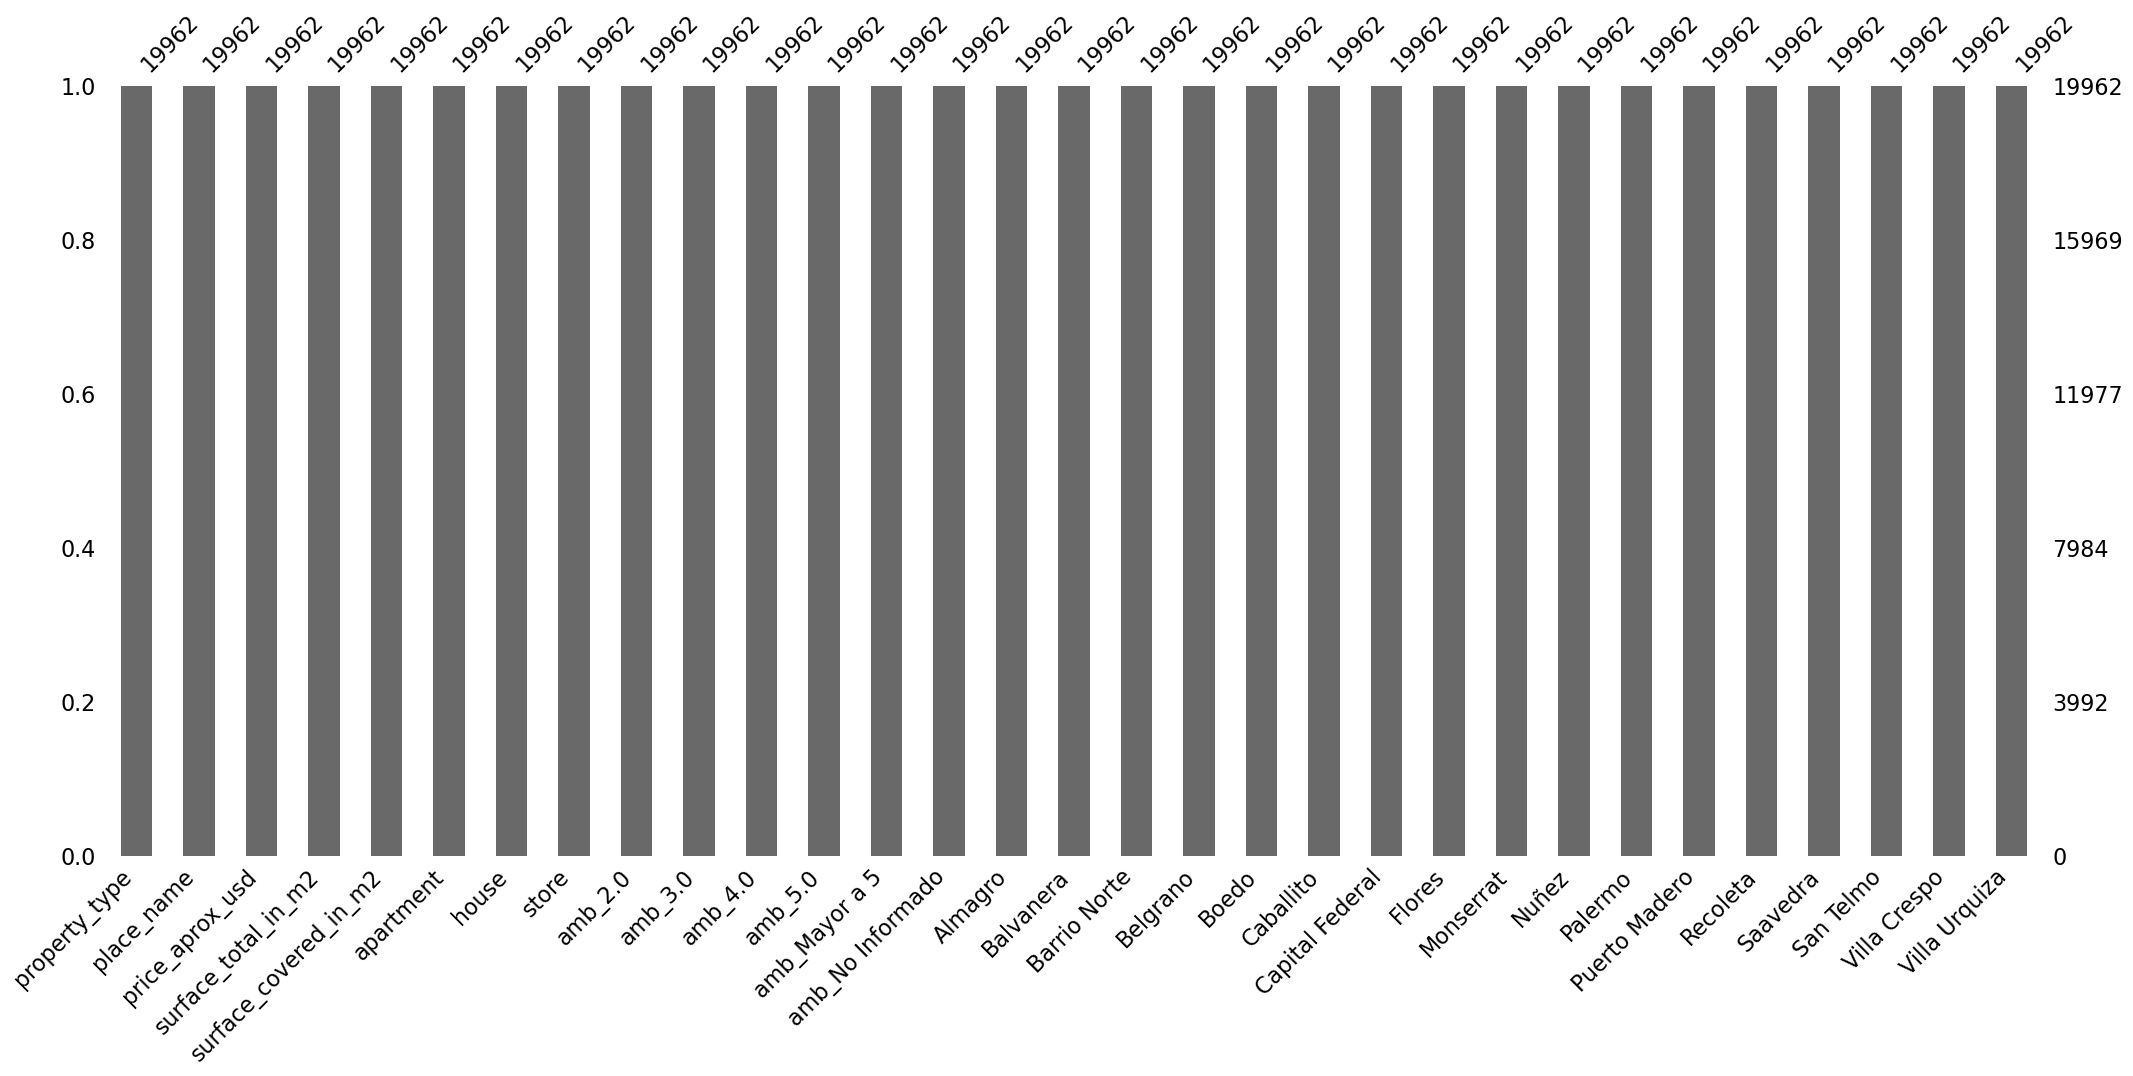

In [16]:
msno.bar(propiedades)

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

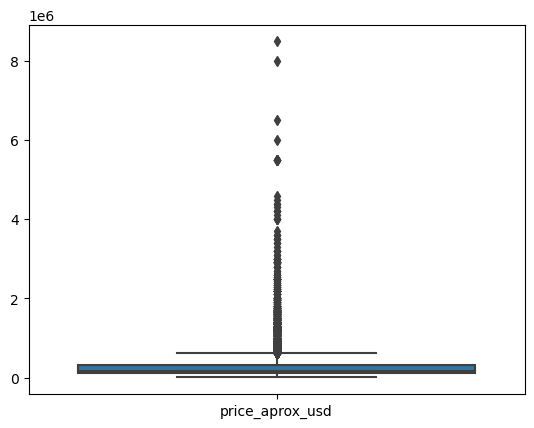

In [17]:
# Generamos algunas gráficas para ver distribución de los datos 
sns.boxplot(data=propiedades[["price_aprox_usd"]], orient="v")

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

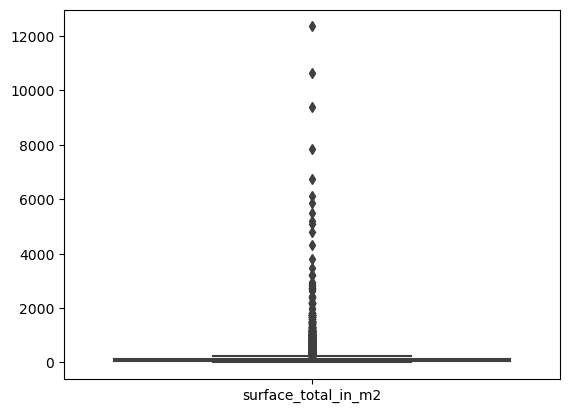

In [18]:
sns.boxplot(data=propiedades[['surface_total_in_m2']], orient="v")

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

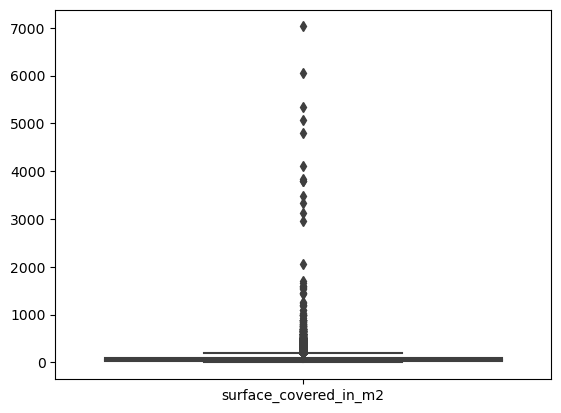

In [19]:
sns.boxplot(data=propiedades[['surface_covered_in_m2']], orient="v")

In [70]:
sns.pairplot(propiedades)

Error in callback <function flush_figures at 0x000001BFAB4FB6D0> (for post_execute):


KeyboardInterrupt: 

[(0.0, 6000.0)]

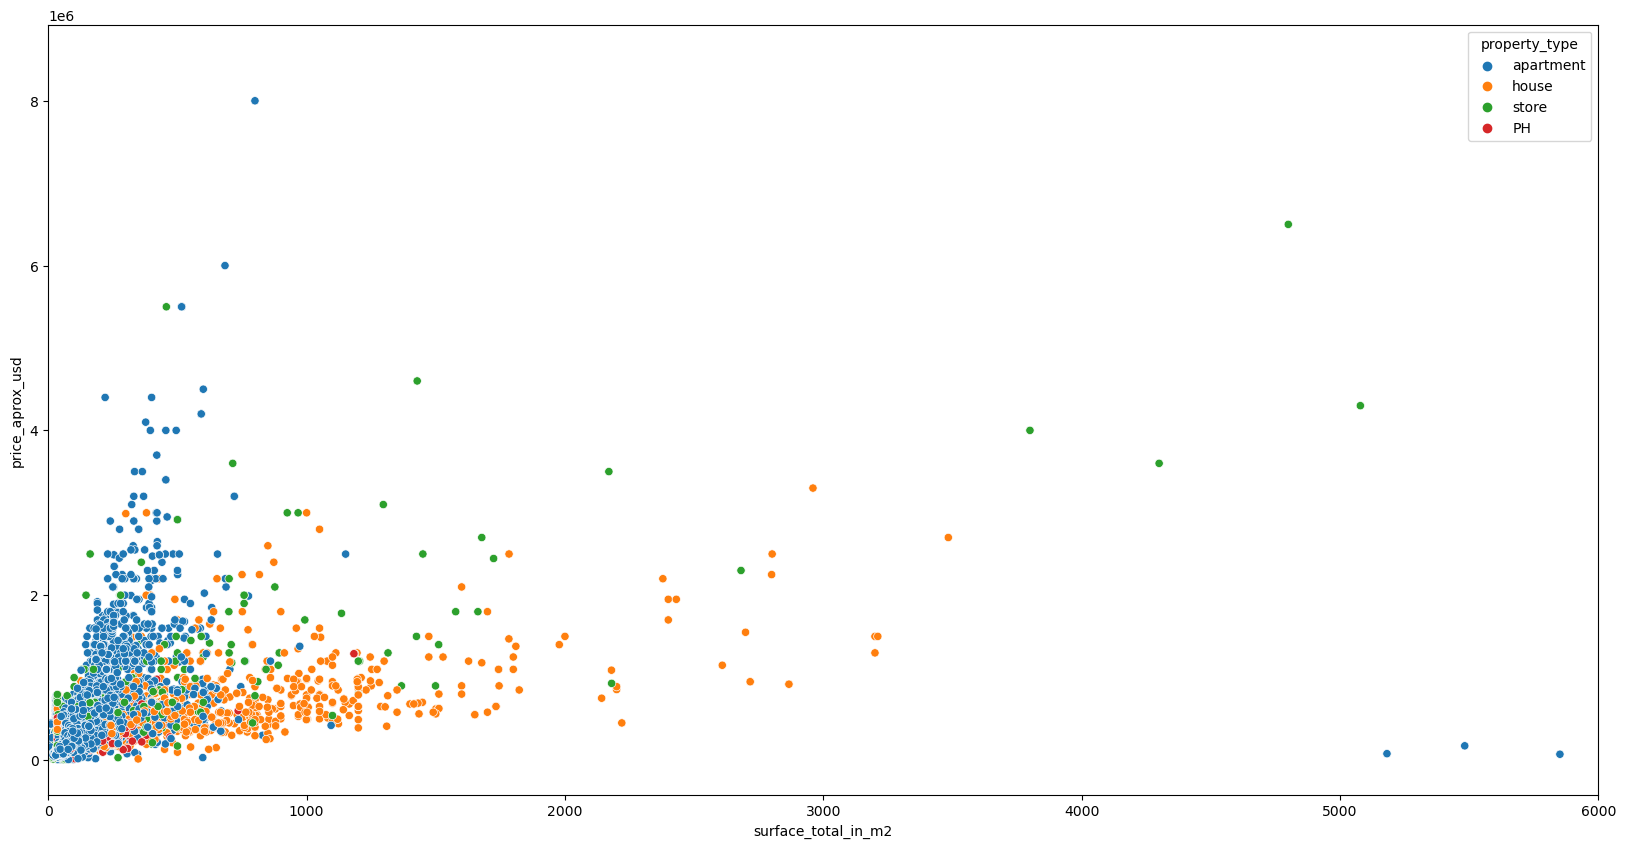

In [20]:
# Estudiamos la existencia de correlación lineal entre la superficie (cubierta y total) con precio aproximado en USD de la propiedad

plt.figure(figsize=(20,10))
tipo_propiedad = sns.scatterplot(x='surface_total_in_m2', y="price_aprox_usd",  data=propiedades, hue='property_type')
tipo_propiedad.set(xlim = (0,6000))
# tipo_propiedad.set(ylim = (0, 500000))

[(0.0, 6000.0)]

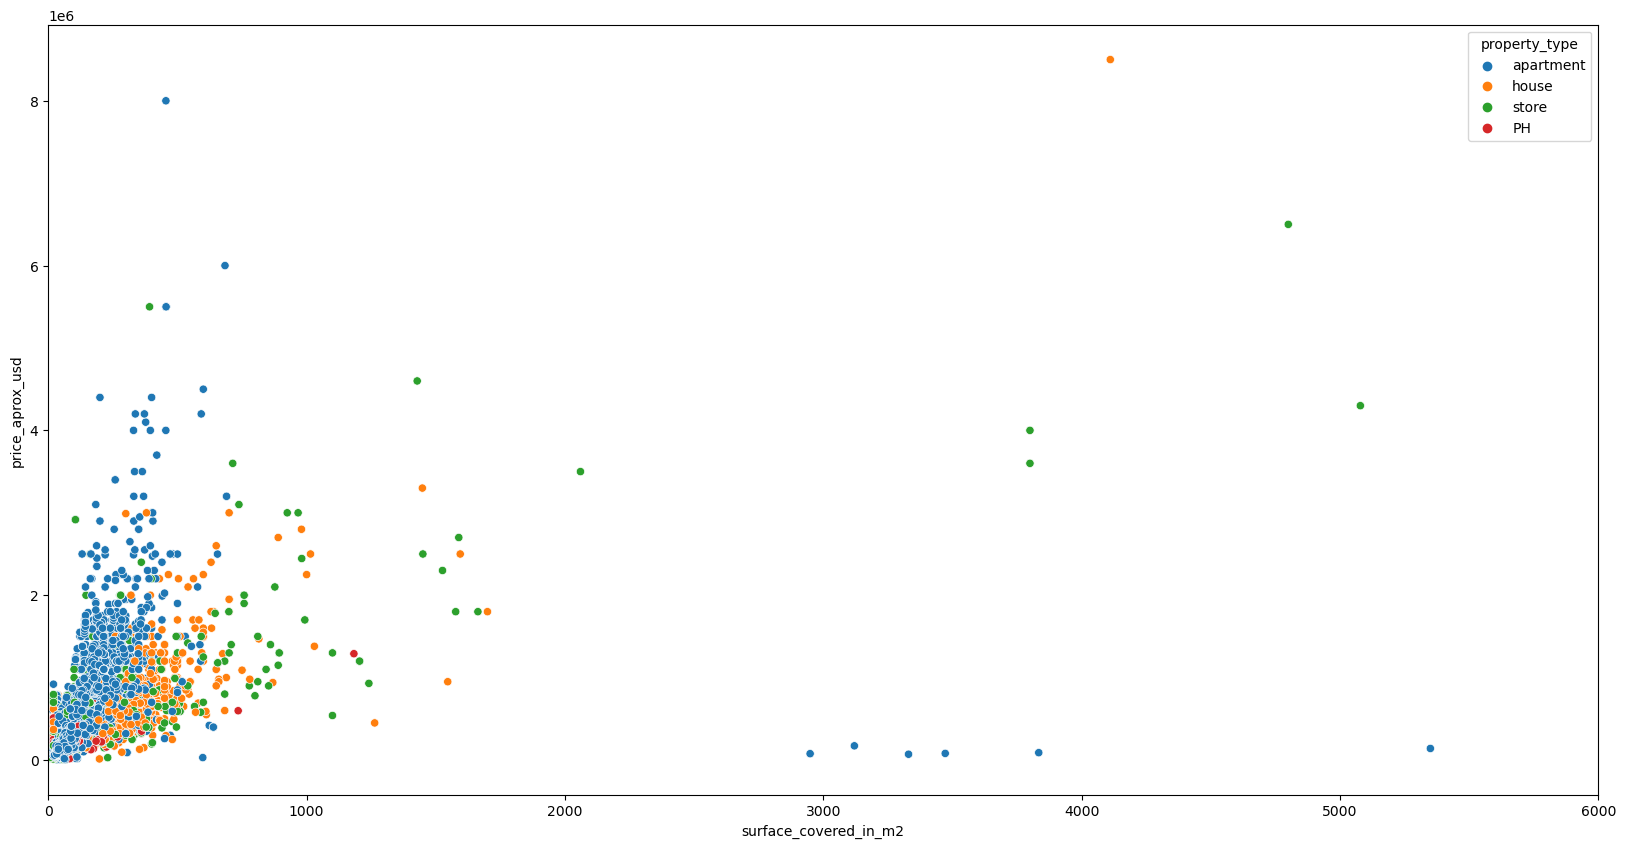

In [21]:
# Estudiamos la existencia de correlación lineal entre la superficie (cubierta y total) con precio aproximado en USD de la propiedad

plt.figure(figsize=(20,10))
tipo_propiedad = sns.scatterplot(x='surface_covered_in_m2', y="price_aprox_usd",  data=propiedades, hue='property_type')
tipo_propiedad.set(xlim = (0,6000))
# tipo_propiedad.set(ylim = (0, 500000))

En la gráfica se evidencia cierta correlación lineal positiva entre superficie (total y cubierta) y precio de la propiedad, independientemente del tipo de propiedad. Con mayores pendientes para los tipos de propiedades apartment y store en comparación con house y PH. 

In [22]:
# Para garantizar que no existen valores nulos en el DataFrame
propiedades.isnull().sum()

property_type            0
place_name               0
price_aprox_usd          0
surface_total_in_m2      0
surface_covered_in_m2    0
apartment                0
house                    0
store                    0
amb_2.0                  0
amb_3.0                  0
amb_4.0                  0
amb_5.0                  0
amb_Mayor a 5            0
amb_No Informado         0
Almagro                  0
Balvanera                0
Barrio Norte             0
Belgrano                 0
Boedo                    0
Caballito                0
Capital Federal          0
Flores                   0
Monserrat                0
Nuñez                    0
Palermo                  0
Puerto Madero            0
Recoleta                 0
Saavedra                 0
San Telmo                0
Villa Crespo             0
Villa Urquiza            0
dtype: int64

## 6. MODELO OLS - MÍNIMO CUADRADOS

## 6.1. Considerando todos los tipos de propiedades - 1era Aproximación.

Buscando diferentes aproximaciones a la solución que resuelva la relación entre precio de las propiedades y el grupo de features, en primer lugar consideramos todos los tipos de propiedades (house, apartment, PH, store).

Antes de ejecutar los números tenemos que definir una hipótesis nula y una hipótesis alternativa:

Hipótesis nula (H0): NO existe asociación entre el tipo de propiedad y el valor aproximado de la propiedad en USD(considerando los factores de confusión elegidos);

Hipótesis Alternativa (H1): Existe asociación entre el tipo de propiedad y el valor aproximado de la propiedad en USD.


In [23]:
# Creando copia del DataFrame original 
prop_prueba = propiedades.copy()
prop_prueba.shape

(19962, 31)

In [24]:
# Para considerar las variables predictoras
feature_cols = [x for x in propiedades.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]

['surface_total_in_m2',
 'surface_covered_in_m2',
 'apartment',
 'house',
 'store',
 'amb_2.0',
 'amb_3.0',
 'amb_4.0',
 'amb_5.0',
 'amb_Mayor a 5',
 'amb_No Informado',
 'Almagro',
 'Balvanera',
 'Barrio Norte',
 'Belgrano',
 'Boedo',
 'Caballito',
 'Capital Federal',
 'Flores',
 'Monserrat',
 'Nuñez',
 'Palermo',
 'Puerto Madero',
 'Recoleta',
 'Saavedra',
 'San Telmo',
 'Villa Crespo',
 'Villa Urquiza']

In [42]:
# División de los datos en train y test
# ==============================================================================
X = prop_prueba[feature_cols]
y = prop_prueba['price_aprox_usd']


X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )   

Como 1er ejercicio vamos a considerar como features solo las columnas relacionadas con superficie (cubierta y total). 

In [46]:
# Para armar el modelo basados en OLS (Ordinary Least Squares) - Mínimos cuadrados
X = X_train[['surface_total_in_m2',
 'surface_covered_in_m2']]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     2729.
Date:                Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:55:14   Log-Likelihood:            -2.2475e+05
No. Observations:               15969   AIC:                         4.495e+05
Df Residuals:                   15966   BIC:                         4.495e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.718e+

El bajo R2 obtenido (<30%) indica que ambas features por si sólo no son suficientes para explicar la variablidad de la mayoría de los resultados en el conjunto de datos de test. 

Por ello, vamos a considerar todas las features en los sucesivos modelos a probar. 

In [44]:
# Para armar el modelo basados en OLS (Ordinary Least Squares) - Mínimos cuadrados
X = X_train[feature_cols]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     434.7
Date:                Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:50:20   Log-Likelihood:            -2.2270e+05
No. Observations:               15969   AIC:                         4.454e+05
Df Residuals:                   15941   BIC:                         4.457e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    6.3e+

A partir del análisis de la tabla resumen, se extrae lo siguiente: 
* El modelo logra explicar el 42% de la variabilidad de los resultados, según el R2 ajustado. 

* Considerando el Intervalo de Confianza (IC) del 95% obtenido para la feature Capital Federal con p-value < 0.05 y que incluye el 0 dentro de dicho intervalo, sugiriendo que la asociación no es estadísticamente significativa, por lo que no se puede rechazar la hipótesis nula de no asociación. Respecto a la variable surface_covered_in_m2 parecería ser la feature con mayor influencia con un alto valor de coeficiente respecto a surface_covered_in_m2, p-valur menor a 0.05, coeficiente cercano a 1500 e IC entre 1278.098 y 1431.973. 

In [45]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, será eliminada la feature Capital Federal 
X_train.drop(['Capital Federal'], axis = 1, inplace =True)
feature_cols = [x for x in X_train.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]


# Para armar el modelo basados en OLS (Ordinary Least Squares) - Mínimos cuadrados
X = X_train[feature_cols]
y = y_train

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print (model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     451.2
Date:                Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:53:52   Log-Likelihood:            -2.2270e+05
No. Observations:               15969   AIC:                         4.454e+05
Df Residuals:                   15942   BIC:                         4.457e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.614e+

Al eliminar la feature Capital Federal no se observa mejoría del R2 para el modelo. En esta 1era aproximación, sin discriminar por tipo de propiedad, el modelo logra explicar solo en un 42% la variabilidad de los resultados. 

Por ello, en una 2da aproximación y en búsqueda de mejorar el modelo serán realizadas otras aproximaciones, por ejemplo: considerar el tipo de propiedad.

## 6.2. Discriminando por tipo de propiedad

In [61]:
# Creando copia del DataFrame original 
prop_prueba = propiedades.copy()
prop_prueba.shape

(19962, 31)

In [ ]:
# División de los datos en train y test
# ==============================================================================
X = prop_prueba[feature_cols]
y = prop_prueba['price_aprox_usd']


X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )   

In [141]:
def tipo_propiedad_train(property_type):
    '''Evaluación del modelo sobre conjunto de datos de train'''
    
    property_type = prop_prueba.loc[prop_prueba['property_type'] == property_type]
    
    feature_cols = [x for x in property_type.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
    # Generando Train y Test 
    X = property_type[feature_cols]
    y = property_type['price_aprox_usd']


    X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     ) 

    # Generando modelo 

    X = X_train[feature_cols]
    y = y_train

    # Tenemos que agregar explícitamente a una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    return model.summary()
    

# 6.2.1. Modelo para Tipo de Propiedad PH

In [142]:
tipo_propiedad_train('PH')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     66.72
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          6.84e-149
Time:                        22:37:48   Log-Likelihood:                -7859.9
No. Observations:                 627   AIC:                         1.577e+04
Df Residuals:                     603   BIC:                         1.587e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.941e+04   1.95e+04      3.040      0.002     2.1e+04    9.78e+04
surface_total_in_m2     415.7442     67.263      6.181      0.000     283.645     547.843
surface_covered_in_m2   554.0399     88.797      6.239      0.000     379.652     728.428
apartment             -4.161e-11   3.82e-11     -1.089      0.277   -1.17e-10    3.34e-11
house                 -1.924e-11   2.33e-11     -0.824      0.410   -6.51e-11    2.66e-11
store                  3.834e-11   1.37e-11      2.802      0.005    1.15e-11    6.52e-11
amb_2.0               -2321.3990   2.31e+04     -0.101      0.920   -4.76e+04     4.3e+04
amb_3.0                2.139e+04   2.19e+04      0.976      0.329   -2.17e+04    6.44e+04
amb_4.0                5.866e+04   2.21e+04      2.655      0.008    1.53e+04    1.02e+05
amb_5.0                8.222e+04   2.29e+04      3.588      0.000    3.72e+04    1.27e+05
amb_Mayor a 5          8.895e+04   2.52e+04      3.525      0.000    3.94e+04    1.39e+05
amb_No Informado       3.877e+04   2.19e+04      1.774      0.077   -4155.047    8.17e+04
Almagro               -1.316e+04   9604.817     -1.370      0.171    -3.2e+04    5705.218
Balvanera             -5.307e+04   1.32e+04     -4.021      0.000    -7.9e+04   -2.72e+04
Barrio Norte           3.648e+04   2.08e+04      1.755      0.080   -4337.132    7.73e+04
Belgrano               8.472e+04   1.11e+04      7.608      0.000    6.29e+04    1.07e+05
Boedo                 -3.888e+04   1.35e+04     -2.890      0.004   -6.53e+04   -1.25e+04
Caballito              -523.9281   9360.770     -0.056      0.955   -1.89e+04    1.79e+04
Capital Federal       -5.543e+04   1.26e+04     -4.408      0.000   -8.01e+04   -3.07e+04
Flores                -4.999e+04   8769.839     -5.700      0.000   -6.72e+04   -3.28e+04
Monserrat             -5.213e+04   2.02e+04     -2.586      0.010   -9.17e+04   -1.25e+04
Nuñez                  6.846e+04   1.37e+04      4.980      0.000    4.15e+04    9.55e+04
Palermo                7.404e+04   8069.270      9.175      0.000    5.82e+04    8.99e+04
Puerto Madero         -2.864e-13   9.83e-14     -2.913      0.004    -4.8e-13   -9.33e-14
Recoleta               5.759e+04   2.21e+04      2.608      0.009    1.42e+04    1.01e+05
Saavedra               1.355e+04   1.19e+04      1.137      0.256   -9853.702    3.69e+04
San Telmo             -2.353e+04   1.42e+04     -1.659      0.098   -5.14e+04    4331.305
Villa Crespo           3266.6333   8795.880      0.371      0.710    -1.4e+04    2.05e+04
Villa Urquiza          8022.3396   8934.340      0.898      0.370   -9523.863    2.56e+04
==============================================================================
Omnibus:                      158.235   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarqu

In [63]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, serán eliminadas las columnas Dummies para Tipo de Propiedad y numero de ambientes 
prop_prueba.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5',
       'amb_No Informado', 'Almagro', 'Balvanera', 'Barrio Norte', 'Belgrano',
       'Boedo', 'Caballito', 'Capital Federal', 'Flores', 'Monserrat', 'Nuñez',
       'Palermo', 'Puerto Madero', 'Recoleta', 'Saavedra', 'San Telmo',
       'Villa Crespo', 'Villa Urquiza'],
      dtype='object')

### 2da Corrida (Tipo Propiedad PH)


In [65]:
tipo_propiedad_train('PH')

       property_type       place_name  price_aprox_usd  surface_total_in_m2  \
7          apartment         Belgrano         138000.0                 45.0   
8          apartment         Belgrano         195000.0                 65.0   
19         apartment          Palermo         350000.0                104.0   
21         apartment          Palermo         270500.0                118.0   
29         apartment           Flores          75000.0                 43.0   
...              ...              ...              ...                  ...   
121160     apartment         Belgrano         410000.0                157.0   
121209     apartment         Belgrano         410000.0                157.0   
121215     apartment         Belgrano         870000.0                113.0   
121217     apartment    Villa Urquiza         131500.0                 46.0   
121219     apartment  Capital Federal         129000.0                 77.0   

        surface_covered_in_m2  amb_4.0  amb_5.0  am

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     72.52
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          9.65e-150
Time:                        16:08:33   Log-Likelihood:                -7862.3
No. Observations:                 627   AIC:                         1.577e+04
Df Residuals:                     605   BIC:                         1.587e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.163e+04   5509.056     13.002      0.000    6.08e+04    8.24e+04
surface_total_in_m2     422.4958     67.338      6.274      0.000     290.251     554.741
surface_covered_in_m2   552.4622     88.987      6.208      0.000     377.701     727.224
amb_4.0                4.414e+04   8426.614      5.238      0.000    2.76e+04    6.07e+04
amb_5.0                6.756e+04   1.03e+04      6.532      0.000    4.72e+04    8.79e+04
amb_Mayor a 5          7.423e+04   1.51e+04      4.910      0.000    4.45e+04    1.04e+05
amb_No Informado       2.412e+04   7558.751      3.191      0.001    9276.251     3.9e+04
Almagro               -1.274e+04   9622.721     -1.324      0.186   -3.16e+04    6153.495
Balvanera              -5.31e+04   1.32e+04     -4.033      0.000    -7.9e+04   -2.72e+04
Barrio Norte           3.852e+04   2.07e+04      1.859      0.064   -2177.811    7.92e+04
Belgrano               8.579e+04    1.1e+04      7.803      0.000    6.42e+04    1.07e+05
Boedo                 -3.736e+04   1.33e+04     -2.803      0.005   -6.35e+04   -1.12e+04
Caballito              1387.0633   9243.982      0.150      0.881   -1.68e+04    1.95e+04
Capital Federal       -5.365e+04   1.25e+04     -4.295      0.000   -7.82e+04   -2.91e+04
Flores                -4.851e+04   8585.337     -5.651      0.000   -6.54e+04   -3.17e+04
Monserrat             -5.749e+04    1.9e+04     -3.020      0.003   -9.49e+04   -2.01e+04
Nuñez                   6.93e+04   1.37e+04      5.073      0.000    4.25e+04    9.61e+04
Palermo                7.569e+04   7862.144      9.627      0.000    6.02e+04    9.11e+04
Puerto Madero         -7.022e-12      6e-12     -1.170      0.243   -1.88e-11    4.77e-12
Recoleta               5.546e+04   2.19e+04      2.528      0.012    1.24e+04    9.85e+04
Saavedra               1.453e+04   1.18e+04      1.234      0.218   -8599.147    3.76e+04
San Telmo             -2.295e+04   1.42e+04     -1.618      0.106   -5.08e+04    4898.247
Villa Crespo           6067.4775   8545.483      0.710      0.478   -1.07e+04    2.28e+04
Villa Urquiza          1.072e+04   8719.811      1.229      0.220   -6409.685    2.78e+04
==============================================================================
Omnibus:                      155.959   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.276
Skew:                           1.074   Prob(JB):                    8.43e-143
Kurtosis:                       7.520   Cond. No.                     5.42e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.81e-31. This might indicate that there are
str

In [66]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, serán eliminadas las columnas Dummies para Tipo de Propiedad y numero de ambientes 
prop_prueba.drop(['Almagro','San Telmo', 'Barrio Norte', 'Caballito', 'Saavedra', 'Villa Crespo', 'Villa Urquiza', 'Puerto Madero'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'amb_4.0', 'amb_5.0', 'amb_Mayor a 5',
       'amb_No Informado', 'Balvanera', 'Belgrano', 'Boedo', 'Capital Federal',
       'Flores', 'Monserrat', 'Nuñez', 'Palermo', 'Recoleta'],
      dtype='object')

## 3era corrida

In [69]:
tipo_propiedad_train('PH')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     100.2
Date:                Tue, 29 Nov 2022   Prob (F-statistic):          1.75e-153
Time:                        16:16:49   Log-Likelihood:                -7867.4
No. Observations:                 627   AIC:                         1.577e+04
Df Residuals:                     611   BIC:                         1.584e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.549e+04   6258.547     12.061      0.000    6.32e+04    8.78e+04
surface_total_in_m2     437.5361     67.177      6.513      0.000     305.610     569.462
surface_covered_in_m2   517.4685     87.594      5.908      0.000     345.447     689.490
amb_4.0                4.303e+04   8388.539      5.130      0.000    2.66e+04    5.95e+04
amb_5.0                6.777e+04   1.03e+04      6.560      0.000    4.75e+04    8.81e+04
amb_Mayor a 5          6.776e+04   1.49e+04      4.533      0.000    3.84e+04    9.71e+04
amb_No Informado       2.677e+04   7508.953      3.565      0.000     1.2e+04    4.15e+04
Balvanera             -5.475e+04   1.42e+04     -3.858      0.000   -8.26e+04   -2.69e+04
Belgrano               8.312e+04   1.19e+04      6.988      0.000    5.98e+04    1.06e+05
Boedo                 -3.988e+04   1.44e+04     -2.775      0.006   -6.81e+04   -1.17e+04
Capital Federal       -5.904e+04   1.34e+04     -4.402      0.000   -8.54e+04   -3.27e+04
Flores                -5.218e+04   9348.506     -5.582      0.000   -7.05e+04   -3.38e+04
Monserrat             -6.061e+04   2.05e+04     -2.963      0.003   -1.01e+05   -2.04e+04
Nuñez                  6.701e+04   1.47e+04      4.562      0.000    3.82e+04    9.59e+04
Palermo                7.255e+04   8649.427      8.388      0.000    5.56e+04    8.95e+04
Recoleta               5.271e+04   2.35e+04      2.245      0.025    6598.612    9.88e+04
==============================================================================
Omnibus:                      158.557   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              657.196
Skew:                           1.098   Prob(JB):                    1.96e-143
Kurtosis:                       7.509   Cond. No.                     1.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A partir de la eliminación de más del 40% de las features del conjunto de train no se logra una mejora considerable del R2 ajustado, manteniéndose alrededor del 70%. Considerando este valor será evaluado la predicción del modelo con el conjunto de test. 

In [82]:
X_test.shape

(3993, 27)

In [75]:
prop_prueba.shape

(19962, 18)

## Evaluando el modelo con datos del conjunto test

In [136]:
def prediccion_modelo(property_type):
    '''Evaluación del modelo sobre conjunto de datos de test'''
    
    property_type = prop_prueba.loc[prop_prueba['property_type'] == property_type]
    
    feature_cols = [x for x in property_type.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'place_name'))]
    
    # Generando Train y Test 
    X = property_type[feature_cols]
    y = property_type['price_aprox_usd']

    X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     ) 
    # Haciendo predicción 
        
    model = LinearRegression()
    model.fit(X_train, y_train)
        
    print(pd.DataFrame(model.coef_, X.columns, columns = ['Coeff']))
    
    predictions = model.predict(X_test) 
    n = len(y_test)
    p = 5
    r2 = metrics.r2_score(y_test, predictions)
    r2_ajustado = 1 - (1 - r2)*((n-1)/(n - p - 1))
    
    MAE = metrics.mean_absolute_error(y_test, predictions)
    MSE = metrics.mean_squared_error(y_test, predictions)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))

    # Preguntar como sacar ambas gráficas 
    # plt.hist(y_test - predictions)
    sns.set(style='whitegrid')
    f = sns.scatterplot(x = y_test, y = predictions)
    f.set_xlabel("Y_test", fontsize = 20)
    f.set_ylabel("Predicción", fontsize = 20)

    
    return ("R2: ", r2) , ("R2 ajustado: ", r2_ajustado) , ('Mean Absolute Error:', MAE), ('Mean Squared Error:', MSE), ('Root Mean Squared Error:', RMSE)

                              Coeff
surface_total_in_m2      437.536068
surface_covered_in_m2    517.468485
amb_4.0                43029.559455
amb_5.0                67769.067312
amb_Mayor a 5          67759.873140
amb_No Informado       26770.287607
Balvanera             -54751.722034
Belgrano               83120.347354
Boedo                 -39876.950044
Capital Federal       -59041.001828
Flores                -52182.894058
Monserrat             -60605.467026
Nuñez                  67006.706658
Palermo                72550.647402
Recoleta               52714.291678


(('R2: ', 0.6573058503293399),
 ('R2 ajustado: ', 0.6459583619296492),
 ('Mean Absolute Error:', 41292.40923617976),
 ('Mean Squared Error:', 3223090469.731339),
 ('Root Mean Squared Error:', 56772.26849203173))

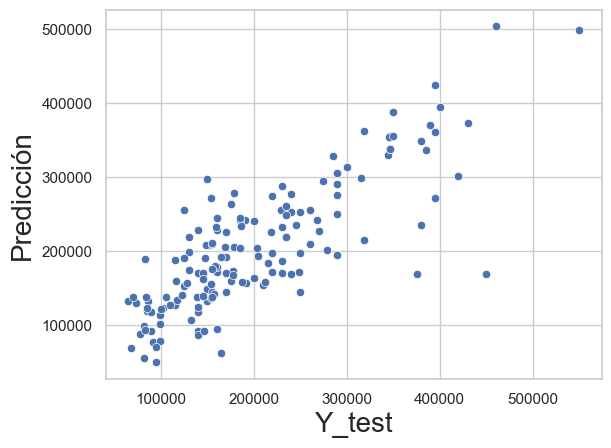

In [137]:
prediccion_modelo('PH')

# Ya está definida la función para training y test. 

# Falta aplicar la función para Apartment, House y Store. 

# Modelo para Tipo de Propiedad Apartment 

In [138]:
# Para la generación del modelo en un nuevo tipo de Propiedad, trabajaremos sobre el DataFrame base. 
prop_prueba = propiedades.copy()

In [139]:
# División de los datos en train y test
# ==============================================================================
X = prop_prueba[feature_cols]
y = prop_prueba['price_aprox_usd']


X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 123,
                                     )  

In [143]:
tipo_propiedad_train('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     586.6
Date:                Tue, 29 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:38:11   Log-Likelihood:            -1.9194e+05
No. Observations:               13958   AIC:                         3.839e+05
Df Residuals:                   13933   BIC:                         3.841e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_total_in_m2   -2776.3811     53.720    -51.682      0.000   -2881.680   -2671.082
surface_covered_in_m2  5373.8954     91.262     58.884      0.000    5195.009    5552.781
apartment              9.633e+04   5129.442     18.780      0.000    8.63e+04    1.06e+05
house                 -1.079e-09   1.76e-10     -6.126      0.000   -1.42e-09   -7.34e-10
store                  4.782e-09   7.11e-10      6.728      0.000    3.39e-09    6.17e-09
amb_2.0               -2.615e+04   7782.644     -3.360      0.001   -4.14e+04   -1.09e+04
amb_3.0                1.401e+04   7934.505      1.765      0.078   -1544.875    2.96e+04
amb_4.0                1.017e+05   8788.041     11.575      0.000    8.45e+04    1.19e+05
amb_5.0                 1.85e+05   1.34e+04     13.804      0.000    1.59e+05    2.11e+05
amb_Mayor a 5          3.453e+05   1.82e+04     19.016      0.000     3.1e+05    3.81e+05
amb_No Informado       1.982e+04   6201.619      3.197      0.001    7668.666     3.2e+04
Almagro               -8.181e+04   8602.582     -9.510      0.000   -9.87e+04   -6.49e+04
Balvanera             -1.193e+05   1.07e+04    -11.197      0.000    -1.4e+05   -9.84e+04
Barrio Norte           -2.69e+04   8264.374     -3.255      0.001   -4.31e+04   -1.07e+04
Belgrano               2.609e+04   5445.511      4.791      0.000    1.54e+04    3.68e+04
Boedo                  1.328e+05   9694.008     13.704      0.000    1.14e+05    1.52e+05
Caballito             -6.066e+04   5980.574    -10.142      0.000   -7.24e+04   -4.89e+04
Capital Federal       -2176.9887   1.21e+04     -0.181      0.857   -2.58e+04    2.15e+04
Flores                -9.394e+04   7888.031    -11.909      0.000   -1.09e+05   -7.85e+04
Monserrat             -1.098e+05   1.17e+04     -9.368      0.000   -1.33e+05   -8.68e+04
Nuñez                  1.063e+05   9842.323     10.805      0.000    8.71e+04    1.26e+05
Palermo                5.036e+04   5542.128      9.086      0.000    3.95e+04    6.12e+04
Puerto Madero          5.092e+05   1.05e+04     48.567      0.000    4.89e+05     5.3e+05
Recoleta               5077.3567   7096.902      0.715      0.474   -8833.523     1.9e+04
Saavedra               -3.46e+04   1.18e+04     -2.924      0.003   -5.78e+04   -1.14e+04
San Telmo              -8.74e+04   7660.758    -11.409      0.000   -1.02e+05   -7.24e+04
Villa Crespo           -7.18e+04   7878.240     -9.113      0.000   -8.72e+04   -5.64e+04
Villa Urquiza         -4.518e+04   7342.795     -6.152      0.000   -5.96e+04   -3.08e+04
==============================================================================
Omnibus:                    15568.707   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3458566.540
Skew:                           5.405   Prob(JB):       

In [ ]:
# Realizando 1era validación considerando sólo las variables predictoras relacionadas con superficie de la propiedad

apartment = prop_prueba.loc[prop_prueba['property_type'] == 'apartment']

X = apartment[['surface_total_in_m2',
       'surface_covered_in_m2']]
y = apartment['price_aprox_usd']

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     4761.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        23:12:37   Log-Likelihood:            -2.4261e+05
No. Observations:               17448   AIC:                         4.852e+05
Df Residuals:                   17445   BIC:                         4.853e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8.289e+

In [ ]:
tipo_propiedad('apartment')

In [ ]:
# Considerando los valores obtenidos para p-values e IC con 95% de confianza, serán eliminadas las columnas Dummies para Tipo de Propiedad y numero de ambientes 
prop_prueba.drop(['apartment', 'house', 'store', 'amb_2.0','amb_3.0', 'amb_4.0', 'amb_5.0', 
                            'amb_Mayor a 5', 'amb_No Informado'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'Almagro', 'Balvanera', 'Barrio Norte',
       'Belgrano', 'Boedo', 'Caballito', 'Capital Federal', 'Flores',
       'Monserrat', 'Nuñez', 'Palermo', 'Puerto Madero', 'Recoleta',
       'Saavedra', 'San Telmo', 'Villa Crespo', 'Villa Urquiza'],
      dtype='object')

In [ ]:
tipo_propiedad('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     825.3
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:52:21   Log-Likelihood:            -2.4104e+05
No. Observations:               17448   AIC:                         4.821e+05
Df Residuals:                   17429   BIC:                         4.823e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.002e+05   2546.794     39.331      0.000    9.52e+04    1.05e+05
surface_total_in_m2   -3316.9239     47.057    -70.487      0.000   -3409.161   -3224.687
surface_covered_in_m2  6379.6947     78.576     81.192      0.000    6225.679    6533.711
Almagro               -8.277e+04   8086.678    -10.236      0.000   -9.86e+04   -6.69e+04
Balvanera             -1.125e+05   9953.510    -11.300      0.000   -1.32e+05    -9.3e+04
Barrio Norte           -1.82e+04   7772.466     -2.342      0.019   -3.34e+04   -2969.955
Belgrano               2.827e+04   5148.425      5.491      0.000    1.82e+04    3.84e+04
Boedo                  1.159e+05   8749.810     13.243      0.000    9.87e+04    1.33e+05
Caballito             -6.203e+04   5645.310    -10.987      0.000   -7.31e+04    -5.1e+04
Capital Federal       -8862.2871   1.15e+04     -0.773      0.440   -3.13e+04    1.36e+04
Flores                -9.609e+04   7428.398    -12.936      0.000   -1.11e+05   -8.15e+04
Monserrat              -9.99e+04   1.11e+04     -8.975      0.000   -1.22e+05   -7.81e+04
Nuñez                  1.096e+05   9426.434     11.630      0.000    9.12e+04    1.28e+05
Palermo                5.357e+04   5241.945     10.219      0.000    4.33e+04    6.38e+04
Puerto Madero          4.876e+05   1.01e+04     48.413      0.000    4.68e+05    5.07e+05
Recoleta               3.611e+04   6727.354      5.367      0.000    2.29e+04    4.93e+04
Saavedra              -3.983e+04   1.15e+04     -3.475      0.001   -6.23e+04   -1.74e+04
San Telmo              -8.75e+04   7283.318    -12.014      0.000   -1.02e+05   -7.32e+04
Villa Crespo           -7.19e+04   7513.782     -9.570      0.000   -8.66e+04   -5.72e+04
Villa Urquiza         -5.133e+04   6925.820     -7.411      0.000   -6.49e+04   -3.78e+04
==============================================================================
Omnibus:                    22384.831   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12239066.747
Skew:                           6.687   Prob(JB):                         0.00
Kurtosis:                     132.059   Cond. No.                     2.43e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.84e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
prop_prueba.drop(['Capital Federal'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'Almagro', 'Balvanera', 'Barrio Norte',
       'Belgrano', 'Boedo', 'Caballito', 'Flores', 'Monserrat', 'Nuñez',
       'Palermo', 'Puerto Madero', 'Recoleta', 'Saavedra', 'San Telmo',
       'Villa Crespo', 'Villa Urquiza'],
      dtype='object')

In [ ]:
tipo_propiedad('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     825.3
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:53:23   Log-Likelihood:            -2.4104e+05
No. Observations:               17448   AIC:                         4.821e+05
Df Residuals:                   17429   BIC:                         4.823e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   9.13e+04   1.21e+04      7.559      0.000    6.76e+04    1.15e+05
surface_total_in_m2   -3316.9239     47.057    -70.487      0.000   -3409.161   -3224.687
surface_covered_in_m2  6379.6947     78.576     81.192      0.000    6225.679    6533.711
Almagro               -7.391e+04   1.46e+04     -5.071      0.000   -1.02e+05   -4.53e+04
Balvanera             -1.036e+05   1.58e+04     -6.548      0.000   -1.35e+05   -7.26e+04
Barrio Norte          -9342.4794   1.44e+04     -0.650      0.516   -3.75e+04    1.88e+04
Belgrano               3.713e+04    1.3e+04      2.859      0.004    1.17e+04    6.26e+04
Boedo                  1.247e+05    1.5e+04      8.316      0.000    9.53e+04    1.54e+05
Caballito             -5.316e+04   1.32e+04     -4.022      0.000   -7.91e+04   -2.73e+04
Flores                -8.723e+04   1.42e+04     -6.153      0.000   -1.15e+05   -5.94e+04
Monserrat             -9.104e+04   1.67e+04     -5.457      0.000   -1.24e+05   -5.83e+04
Nuñez                  1.185e+05   1.55e+04      7.667      0.000    8.82e+04    1.49e+05
Palermo                6.243e+04    1.3e+04      4.791      0.000    3.69e+04     8.8e+04
Puerto Madero          4.965e+05   1.59e+04     31.234      0.000    4.65e+05    5.28e+05
Recoleta               4.497e+04   1.38e+04      3.266      0.001     1.8e+04     7.2e+04
Saavedra              -3.097e+04   1.69e+04     -1.829      0.067   -6.42e+04    2220.551
San Telmo             -7.864e+04   1.41e+04     -5.581      0.000   -1.06e+05    -5.1e+04
Villa Crespo          -6.304e+04   1.42e+04     -4.431      0.000   -9.09e+04   -3.52e+04
Villa Urquiza         -4.247e+04   1.39e+04     -3.058      0.002   -6.97e+04   -1.52e+04
==============================================================================
Omnibus:                    22384.831   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12239066.747
Skew:                           6.687   Prob(JB):                         0.00
Kurtosis:                     132.059   Cond. No.                     6.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
prop_prueba.drop(['Barrio Norte'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'Almagro', 'Balvanera', 'Belgrano', 'Boedo',
       'Caballito', 'Flores', 'Monserrat', 'Nuñez', 'Palermo', 'Puerto Madero',
       'Recoleta', 'Saavedra', 'San Telmo', 'Villa Crespo', 'Villa Urquiza'],
      dtype='object')

In [ ]:
tipo_propiedad('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     873.9
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:54:17   Log-Likelihood:            -2.4104e+05
No. Observations:               17448   AIC:                         4.821e+05
Df Residuals:                   17430   BIC:                         4.822e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8.489e+04   6951.520     12.211      0.000    7.13e+04    9.85e+04
surface_total_in_m2   -3315.1779     46.980    -70.566      0.000   -3407.263   -3223.093
surface_covered_in_m2  6376.5617     78.426     81.307      0.000    6222.838    6530.285
Almagro               -6.744e+04   1.06e+04     -6.339      0.000   -8.83e+04   -4.66e+04
Balvanera             -9.714e+04   1.23e+04     -7.905      0.000   -1.21e+05   -7.31e+04
Belgrano               4.363e+04   8295.113      5.259      0.000    2.74e+04    5.99e+04
Boedo                  1.312e+05   1.12e+04     11.680      0.000    1.09e+05    1.53e+05
Caballito             -4.669e+04   8687.967     -5.374      0.000   -6.37e+04   -2.97e+04
Flores                -8.076e+04   1.01e+04     -8.009      0.000   -1.01e+05    -6.1e+04
Monserrat             -8.457e+04   1.34e+04     -6.317      0.000   -1.11e+05   -5.83e+04
Nuñez                   1.25e+05   1.18e+04     10.578      0.000    1.02e+05    1.48e+05
Palermo                6.892e+04   8370.153      8.234      0.000    5.25e+04    8.53e+04
Puerto Madero           5.03e+05   1.23e+04     40.922      0.000    4.79e+05    5.27e+05
Recoleta                5.15e+04   9410.904      5.472      0.000    3.31e+04    6.99e+04
Saavedra              -2.451e+04   1.37e+04     -1.788      0.074   -5.14e+04    2358.946
San Telmo             -7.218e+04   9978.911     -7.233      0.000   -9.17e+04   -5.26e+04
Villa Crespo          -5.657e+04   1.02e+04     -5.566      0.000   -7.65e+04   -3.66e+04
Villa Urquiza           -3.6e+04   9691.281     -3.715      0.000    -5.5e+04    -1.7e+04
==============================================================================
Omnibus:                    22387.612   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12240401.764
Skew:                           6.689   Prob(JB):                         0.00
Kurtosis:                     132.065   Cond. No.                     3.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
prop_prueba.drop(['Saavedra'], axis = 1, inplace =True)
prop_prueba.columns

Index(['property_type', 'place_name', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'Almagro', 'Balvanera', 'Belgrano', 'Boedo',
       'Caballito', 'Flores', 'Monserrat', 'Nuñez', 'Palermo', 'Puerto Madero',
       'Recoleta', 'San Telmo', 'Villa Crespo', 'Villa Urquiza'],
      dtype='object')

In [ ]:
tipo_propiedad('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     928.2
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:58:45   Log-Likelihood:            -2.4104e+05
No. Observations:               17448   AIC:                         4.821e+05
Df Residuals:                   17431   BIC:                         4.822e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  7.889e+04   6088.548     12.957      0.000     6.7e+04    9.08e+04
surface_total_in_m2   -3321.6543     46.843    -70.910      0.000   -3413.471   -3229.837
surface_covered_in_m2  6388.1366     78.163     81.728      0.000    6234.928    6541.345
Almagro               -6.164e+04   1.01e+04     -6.083      0.000   -8.15e+04   -4.18e+04
Balvanera             -9.135e+04   1.19e+04     -7.706      0.000   -1.15e+05   -6.81e+04
Belgrano               4.935e+04   7653.520      6.448      0.000    3.43e+04    6.43e+04
Boedo                   1.37e+05   1.07e+04     12.752      0.000    1.16e+05    1.58e+05
Caballito              -4.09e+04   8061.195     -5.073      0.000   -5.67e+04   -2.51e+04
Flores                -7.497e+04   9549.389     -7.850      0.000   -9.37e+04   -5.62e+04
Monserrat             -7.875e+04    1.3e+04     -6.064      0.000   -1.04e+05   -5.33e+04
Nuñez                  1.308e+05   1.14e+04     11.509      0.000    1.08e+05    1.53e+05
Palermo                7.466e+04   7730.590      9.657      0.000    5.95e+04    8.98e+04
Puerto Madero          5.086e+05   1.19e+04     42.740      0.000    4.85e+05    5.32e+05
Recoleta               5.708e+04   8878.202      6.430      0.000    3.97e+04    7.45e+04
San Telmo             -6.635e+04   9431.819     -7.035      0.000   -8.48e+04   -4.79e+04
Villa Crespo          -5.076e+04   9630.724     -5.270      0.000   -6.96e+04   -3.19e+04
Villa Urquiza         -3.017e+04   9125.388     -3.306      0.001   -4.81e+04   -1.23e+04
==============================================================================
Omnibus:                    22383.575   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12230473.707
Skew:                           6.687   Prob(JB):                         0.00
Kurtosis:                     132.013   Cond. No.                     3.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Eliminando columnas relacionadas con superficie de la propiedad 

In [ ]:
prop_prueba.drop(['surface_total_in_m2',
       'surface_covered_in_m2'], axis = 1, inplace =True)
prop_prueba.columns

Provoca una disminución considerable de más del XX% en para R2 , implicando menor poder predictivo para la variable precio por el modelo.

In [ ]:
tipo_propiedad('apartment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     301.4
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        23:04:20   Log-Likelihood:            -2.4452e+05
No. Observations:               17448   AIC:                         4.891e+05
Df Residuals:                   17433   BIC:                         4.892e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.562e+05   7055.808     36.316      0.000    2.42e+05     2.7e+05
Almagro       -1.053e+05   1.24e+04     -8.521      0.000    -1.3e+05   -8.11e+04
Balvanera     -1.267e+05   1.45e+04     -8.756      0.000   -1.55e+05   -9.83e+04
Belgrano       5.311e+04   9343.415      5.684      0.000    3.48e+04    7.14e+04
Boedo          5.405e+04   1.31e+04      4.134      0.000    2.84e+04    7.97e+04
Caballito     -8.468e+04   9824.834     -8.619      0.000   -1.04e+05   -6.54e+04
Flores        -1.152e+05   1.16e+04     -9.893      0.000   -1.38e+05   -9.24e+04
Monserrat     -1.402e+05   1.58e+04     -8.855      0.000   -1.71e+05   -1.09e+05
Nuñez          9.063e+04   1.39e+04      6.540      0.000    6.35e+04    1.18e+05
Palermo        6.822e+04   9436.015      7.230      0.000    4.97e+04    8.67e+04
Puerto Madero  6.328e+05   1.44e+04     43.840      0.000    6.05e+05    6.61e+05
Recoleta       1.432e+05   1.08e+04     13.283      0.000    1.22e+05    1.64e+05
San Telmo     -1.334e+05   1.15e+04    -11.616      0.000   -1.56e+05   -1.11e+05
Villa Crespo  -1.121e+05   1.17e+04     -9.555      0.000   -1.35e+05   -8.91e+04
Villa Urquiza -1.005e+05   1.11e+04     -9.052      0.000   -1.22e+05   -7.87e+04
==============================================================================
Omnibus:                    21642.096   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5730250.314
Skew:                           6.554   Prob(JB):                         0.00
Kurtosis:                      90.808   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Modelo para Tipo de Propiedad House 

In [ ]:
# Para la generación del modelo en un nuevo tipo de Propiedad, trabajaremos sobre el DataFrame base. 
prop_prueba = propiedades.copy()

In [ ]:
# Realizando 1era validación considerando sólo las variables predictoras relacionadas con superficie de la propiedad

house = prop_prueba.loc[prop_prueba['property_type'] == 'house']

X = house[['surface_total_in_m2',
       'surface_covered_in_m2']]
y = house['price_aprox_usd']

# Será agregada explícitamente una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        price_aprox_usd   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     841.5
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          1.47e-214
Time:                        23:25:44   Log-Likelihood:                -13995.
No. Observations:                 997   AIC:                         2.800e+04
Df Residuals:                     994   BIC:                         2.801e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  9.613e+

In [ ]:
tipo_propiedad('house')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     107.6
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          6.37e-254
Time:                        23:26:11   Log-Likelihood:                -13843.
No. Observations:                 997   AIC:                         2.774e+04
Df Residuals:                     972   BIC:                         2.786e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
surface_total_in_m2     265.9630     28.435      9.353      0.000     210.163     321.763
surface_covered_in_m2  1293.7430     67.934     19.044      0.000    1160.429    1427.057
apartment             -4.059e-09   8.81e-10     -4.610      0.000   -5.79e-09   -2.33e-09
house                  2.798e+05   6.64e+04      4.216      0.000     1.5e+05     4.1e+05
store                  1.708e-08   3.37e-09      5.070      0.000    1.05e-08    2.37e-08
amb_2.0               -2.893e+05   1.13e+05     -2.562      0.011   -5.11e+05   -6.77e+04
amb_3.0               -1.969e+05    1.1e+05     -1.792      0.073   -4.12e+05    1.87e+04
amb_4.0                 -1.8e+05   7.78e+04     -2.314      0.021   -3.33e+05   -2.74e+04
amb_5.0               -1.408e+05   7.59e+04     -1.855      0.064    -2.9e+05    8162.646
amb_Mayor a 5         -1.419e+05   7.52e+04     -1.886      0.060    -2.9e+05    5746.180
amb_No Informado      -1.301e+05   7.07e+04     -1.838      0.066   -2.69e+05    8777.264
Almagro               -1.208e+05   4.96e+04     -2.435      0.015   -2.18e+05   -2.34e+04
Balvanera             -1.873e+05   1.13e+05     -1.660      0.097   -4.09e+05    3.41e+04
Barrio Norte           4.498e+05   9.67e+04      4.652      0.000     2.6e+05     6.4e+05
Belgrano               2.926e+05   3.17e+04      9.232      0.000     2.3e+05    3.55e+05
Boedo                  -4.56e+04   4.78e+04     -0.953      0.341   -1.39e+05    4.83e+04
Caballito             -3.208e+04    3.7e+04     -0.868      0.386   -1.05e+05    4.04e+04
Capital Federal        -1.72e+05   2.65e+04     -6.491      0.000   -2.24e+05    -1.2e+05
Flores                -1.477e+05   3.27e+04     -4.517      0.000   -2.12e+05   -8.35e+04
Monserrat              -2.65e+05   1.26e+05     -2.100      0.036   -5.13e+05   -1.73e+04
Nuñez                  5.757e+04   4.43e+04      1.301      0.194   -2.93e+04    1.44e+05
Palermo                2.517e+05   3.68e+04      6.832      0.000    1.79e+05    3.24e+05
Puerto Madero          3.366e+05   1.27e+05      2.653      0.008    8.76e+04    5.86e+05
Recoleta               1.125e+05   1.46e+05      0.772      0.440   -1.74e+05    3.99e+05
Saavedra              -7.404e+04   4.27e+04     -1.734      0.083   -1.58e+05    9769.315
San Telmo             -1.248e+05   7.74e+04     -1.614      0.107   -2.77e+05     2.7e+04
Villa Crespo           1.279e+04   4.91e+04      0.260      0.795   -8.36e+04    1.09e+05
Villa Urquiza         -6.444e+04   3.72e+04     -1.731      0.084   -1.37e+05    8609.927
==============================================================================
Omnibus:                      425.662   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9733.750
Skew:                           1.413   Prob(JB):       

In [ ]:
tipo_propiedad('store')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     169.7
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:02:34   Log-Likelihood:                -42192.
No. Observations:                2891   AIC:                         8.442e+04
Df Residuals:                    2874   BIC:                         8.452e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2            274.3246     31.141      8.809      0.000     213.263     335.386
surface_covered_in_m2          173.9831     36.454      4.773      0.000     102.504     245.462
apartment                     2.513e-11    2.6e-10      0.097      0.923   -4.85e-10    5.36e-10
house                        -1.945e-11   6.33e-11     -0.308      0.758   -1.44e-10    1.05e-10
store                          1.73e+05   1.06e+05      1.626      0.104   -3.56e+04    3.82e+05
amb_2.0                      -7.951e+04   2.37e+05     -0.336      0.737   -5.44e+05    3.85e+05
amb_3.0                      -9.995e+04    2.1e+05     -0.475      0.635   -5.13e+05    3.13e+05
amb_4.0                       7133.0220   2.81e+05      0.025      0.980   -5.45e+05    5.59e+05
amb_5.0                       9.827e+04   5.39e+05      0.182      0.855   -9.59e+05    1.16e+06
amb_Mayor a 5                 2.153e+04   2.02e+05      0.107      0.915   -3.74e+05    4.17e+05
amb_No Informado              3.843e+04   9.59e+04      0.401      0.689    -1.5e+05    2.26e+05
Bs.As. G.B.A. Zona Norte      8.066e+04   5.18e+04      1.557      0.120   -2.09e+04    1.82e+05
Bs.As. G.B.A. Zona Oeste     -2.272e+04   6.15e+04     -0.369      0.712   -1.43e+05    9.79e+04
Bs.As. G.B.A. Zona Sur       -3.259e+04   5.23e+04     -0.623      0.533   -1.35e+05    6.99e+04
Buenos Aires Costa Atlántica  -8.84e+04   6.06e+04     -1.460      0.144   -2.07e+05    3.03e+04
Buenos Aires Interior        -8.164e+04   9.46e+04     -0.863      0.388   -2.67e+05    1.04e+05
Capital Federal               1.726e+05   4.88e+04      3.534      0.000    7.68e+04    2.68e+05
Córdoba                      -9.338e+04    5.9e+04     -1.583      0.114   -2.09e+05    2.23e+04
Santa Fe                     -8.213e+04   7.87e+04     -1.043      0.297   -2.36e+05    7.22e+04
==============================================================================
Omnibus:                     1174.586   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           398543.625
Skew:                           0.617   Prob(JB):                         0.00
Kurtosis:                      60.507   Cond. No.                     3.76e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.65e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## DUDAS:

Al preparar el OLS para cada tipo de propiedad: 
* Hay que extraer la columna dummy que tenga su nombre? 
* En caso contrario, ¿cómo interpretar su coeficiente? 

## 2.2 Discriminando por tipo de propiedad y ubicación

In [ ]:
def OLS_ubicacion_propiedad(property_type, ubicacion = 'Capital Federal'):
    property_type = propiedades.loc[(propiedades['property_type'] == property_type) & (propiedades['state_name'] == ubicacion) ]
    feature_cols = [x for x in property_type.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'state_name'))]
    
    # Generando modelo OLS
    X = property_type[feature_cols]
    y = property_type['price_aprox_usd']

    # Será agregada explícitamente una constante:
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    return model.summary()

In [ ]:
OLS_ubicacion_propiedad('apartment')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     1626.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        17:34:53   Log-Likelihood:            -3.2667e+05
No. Observations:               23575   AIC:                         6.533e+05
Df Residuals:                   23566   BIC:                         6.534e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2          -3389.8815     45.840    -73.950      0.000   -3479.731   -3300.032
surface_covered_in_m2         6290.2352     78.912     79.712      0.000    6135.562    6444.908
apartment                     4.072e+04   2146.884     18.966      0.000    3.65e+04    4.49e+04
house                          1.38e-11   3.54e-12      3.901      0.000    6.87e-12    2.07e-11
store                         7.194e-12   1.52e-12      4.720      0.000    4.21e-12    1.02e-11
amb_2.0                      -1.771e+04   6223.322     -2.846      0.004   -2.99e+04   -5510.704
amb_3.0                       1.176e+04   6338.128      1.856      0.063    -659.023    2.42e+04
amb_4.0                       7.701e+04   7297.028     10.554      0.000    6.27e+04    9.13e+04
amb_5.0                       2.186e+05   1.16e+04     18.800      0.000    1.96e+05    2.41e+05
amb_Mayor a 5                 2.497e+05   1.52e+04     16.391      0.000     2.2e+05     2.8e+05
amb_No Informado              5364.7275   4912.321      1.092      0.275   -4263.739     1.5e+04
Bs.As. G.B.A. Zona Norte              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal               4.072e+04   2146.884     18.966      0.000    3.65e+04    4.49e+04
Córdoba                               0          0        nan        nan           0           0
Santa Fe                              0          0        nan        nan           0           0
==============================================================================
Omnibus:                    32163.983   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18958831.862
Skew:                           7.555   Prob(JB):                         0.00
Kurtosis:                     141.102   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
OLS_ubicacion_propiedad('house')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     79.84
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          5.17e-113
Time:                        16:25:33   Log-Likelihood:                -25979.
No. Observations:                1802   AIC:                         5.198e+04
Df Residuals:                    1793   BIC:                         5.203e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2            118.9894     37.528      3.171      0.002      45.386     192.593
surface_covered_in_m2          716.3417     78.844      9.086      0.000     561.706     870.977
apartment                    -3.001e-11   1.73e-11     -1.731      0.084    -6.4e-11       4e-12
house                         1.284e+05   4.34e+04      2.957      0.003    4.32e+04    2.14e+05
store                         3.617e-11   4.81e-11      0.752      0.452   -5.82e-11    1.31e-10
amb_2.0                      -1.381e+05   1.54e+05     -0.894      0.371   -4.41e+05    1.65e+05
amb_3.0                      -1.298e+05   1.05e+05     -1.232      0.218   -3.36e+05    7.69e+04
amb_4.0                      -1.274e+05   9.48e+04     -1.344      0.179   -3.13e+05    5.85e+04
amb_5.0                      -2.913e+04   9.41e+04     -0.310      0.757   -2.14e+05    1.55e+05
amb_Mayor a 5                 7.833e+04   9.48e+04      0.826      0.409   -1.08e+05    2.64e+05
amb_No Informado              4.669e+04    8.8e+04      0.530      0.596   -1.26e+05    2.19e+05
Bs.As. G.B.A. Zona Norte              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal               1.284e+05   4.34e+04      2.957      0.003    4.32e+04    2.14e+05
Córdoba                               0          0        nan        nan           0           0
Santa Fe                              0          0        nan        nan           0           0
==============================================================================
Omnibus:                     1169.799   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           525851.341
Skew:                           1.768   Prob(JB):                         0.00
Kurtosis:                      86.613   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
OLS_ubicacion_propiedad('store', 'Córdoba')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     23.11
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           1.26e-20
Time:                        16:02:34   Log-Likelihood:                -2967.0
No. Observations:                 206   AIC:                             5948.
Df Residuals:                     199   BIC:                             5971.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2            693.0833     73.486      9.431      0.000     548.171     837.995
surface_covered_in_m2         -618.9443     79.967     -7.740      0.000    -776.636    -461.252
apartment                     3.107e-11   1.16e-10      0.268      0.789   -1.98e-10     2.6e-10
house                         1.975e-11    3.6e-11      0.548      0.584   -5.13e-11    9.08e-11
store                        -5779.1129   1.57e+05     -0.037      0.971   -3.15e+05    3.03e+05
amb_2.0                       1.206e+05   4.43e+05      0.272      0.786   -7.53e+05    9.94e+05
amb_3.0                       4.479e+04   4.04e+05      0.111      0.912   -7.53e+05    8.42e+05
amb_4.0                       5.065e+04   5.42e+05      0.093      0.926   -1.02e+06    1.12e+06
amb_5.0                               0          0        nan        nan           0           0
amb_Mayor a 5                         0          0        nan        nan           0           0
amb_No Informado              2.051e+05   3.15e+05      0.652      0.515   -4.16e+05    8.26e+05
Bs.As. G.B.A. Zona Norte              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal                       0          0        nan        nan           0           0
Córdoba                      -5779.1129   1.57e+05     -0.037      0.971   -3.15e+05    3.03e+05
Santa Fe                              0          0        nan        nan           0           0
==============================================================================
Omnibus:                      188.903   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3303.994
Skew:                           3.572   Prob(JB):                         0.00
Kurtosis:                      21.273   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
OLS_ubicacion_propiedad('store', 'Santa Fe')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     26.08
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           4.50e-09
Time:                        16:30:55   Log-Likelihood:                -957.87
No. Observations:                  69   AIC:                             1922.
Df Residuals:                      66   BIC:                             1928.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2            505.9757    623.097      0.812      0.420    -738.078    1750.030
surface_covered_in_m2           34.8607    632.117      0.055      0.956   -1227.202    1296.923
apartment                             0          0        nan        nan           0           0
house                                 0          0        nan        nan           0           0
store                         3.706e+04   1.18e+04      3.143      0.003    1.35e+04    6.06e+04
amb_2.0                               0          0        nan        nan           0           0
amb_3.0                               0          0        nan        nan           0           0
amb_4.0                               0          0        nan        nan           0           0
amb_5.0                               0          0        nan        nan           0           0
amb_Mayor a 5                         0          0        nan        nan           0           0
amb_No Informado              3.706e+04   1.18e+04      3.143      0.003    1.35e+04    6.06e+04
Bs.As. G.B.A. Zona Norte              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal                       0          0        nan        nan           0           0
Córdoba                               0          0        nan        nan           0           0
Santa Fe                      3.706e+04   1.18e+04      3.143      0.003    1.35e+04    6.06e+04
==============================================================================
Omnibus:                      111.667   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3005.606
Skew:                           5.167   Prob(JB):                         0.00
Kurtosis:                      33.637   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
OLS_ubicacion_propiedad('apartment', 'Santa Fe')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     69.47
Date:                Mon, 28 Nov 2022   Prob (F-statistic):          1.93e-107
Time:                        16:31:45   Log-Likelihood:                -55123.
No. Observations:                4071   AIC:                         1.103e+05
Df Residuals:                    4062   BIC:                         1.103e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2             -0.7788      3.914     -0.199      0.842      -8.452       6.894
surface_covered_in_m2           86.2705     27.854      3.097      0.002      31.661     140.880
apartment                     3.699e+04   4425.789      8.357      0.000    2.83e+04    4.57e+04
house                         1.234e-10   8.65e-12     14.268      0.000    1.06e-10     1.4e-10
store                         1.216e-11   6.68e-12      1.820      0.069   -9.39e-13    2.53e-11
amb_2.0                       1.055e+04   1.19e+04      0.883      0.377   -1.29e+04     3.4e+04
amb_3.0                       4.631e+04   1.39e+04      3.328      0.001     1.9e+04    7.36e+04
amb_4.0                       1.422e+05   1.84e+04      7.735      0.000    1.06e+05    1.78e+05
amb_5.0                       4.737e+05   2.42e+04     19.571      0.000    4.26e+05    5.21e+05
amb_Mayor a 5                 2.588e+05   3.44e+04      7.527      0.000    1.91e+05    3.26e+05
amb_No Informado              1.506e+04   9519.011      1.582      0.114   -3604.445    3.37e+04
Bs.As. G.B.A. Zona Norte              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal                       0          0        nan        nan           0           0
Córdoba                               0          0        nan        nan           0           0
Santa Fe                      3.699e+04   4425.789      8.357      0.000    2.83e+04    4.57e+04
==============================================================================
Omnibus:                     7410.819   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9279142.720
Skew:                          13.344   Prob(JB):                         0.00
Kurtosis:                     235.361   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# Mayor cantidad de propiedades para Bs.As. G.B.A. Zona Norte

OLS_ubicacion_propiedad('house', 'Bs.As. G.B.A. Zona Norte')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1168.
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:29:40   Log-Likelihood:            -1.7197e+05
No. Observations:               12200   AIC:                         3.440e+05
Df Residuals:                   12191   BIC:                         3.440e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2              5.9158      3.030      1.952      0.051      -0.024      11.855
surface_covered_in_m2         1617.2680     17.930     90.197      0.000    1582.121    1652.415
apartment                     9.362e-12   2.41e-11      0.388      0.698   -3.79e-11    5.67e-11
house                        -3.203e+04   3.78e+04     -0.847      0.397   -1.06e+05    4.21e+04
store                        -3.516e-11    2.1e-11     -1.673      0.094   -7.64e-11    6.05e-12
amb_2.0                       6.038e+04   9.13e+04      0.661      0.509   -1.19e+05    2.39e+05
amb_3.0                       5.442e+04   7.78e+04      0.699      0.484   -9.81e+04    2.07e+05
amb_4.0                       3.736e+04   7.67e+04      0.487      0.626   -1.13e+05    1.88e+05
amb_5.0                       1.018e+05   7.69e+04      1.324      0.186   -4.89e+04    2.53e+05
amb_Mayor a 5                  9.74e+04   7.73e+04      1.260      0.208   -5.41e+04    2.49e+05
amb_No Informado              1.128e+05   7.56e+04      1.492      0.136   -3.53e+04    2.61e+05
Bs.As. G.B.A. Zona Norte     -3.203e+04   3.78e+04     -0.847      0.397   -1.06e+05    4.21e+04
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal                       0          0        nan        nan           0           0
Córdoba                               0          0        nan        nan           0           0
Santa Fe                              0          0        nan        nan           0           0
==============================================================================
Omnibus:                    16299.256   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         41725383.412
Skew:                           6.656   Prob(JB):                         0.00
Kurtosis:                     289.191   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
OLS_ubicacion_propiedad('apartment', 'Bs.As. G.B.A. Zona Norte')

c:\Users\mpire\anaconda3\envs\DH\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_aprox_usd   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     212.2
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:32:44   Log-Likelihood:            -1.2648e+05
No. Observations:                9522   AIC:                         2.530e+05
Df Residuals:                    9513   BIC:                         2.530e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
surface_total_in_m2            -44.6101     11.114     -4.014      0.000     -66.396     -22.824
surface_covered_in_m2          225.4561     22.040     10.229      0.000     182.253     268.659
apartment                     5.318e+04   3656.192     14.546      0.000     4.6e+04    6.04e+04
house                         6.233e-12   2.32e-12      2.682      0.007    1.68e-12    1.08e-11
store                        -1.218e-10   8.98e-12    -13.562      0.000   -1.39e-10   -1.04e-10
amb_2.0                       2.634e+04   8063.231      3.266      0.001    1.05e+04    4.21e+04
amb_3.0                       1.008e+05   8291.252     12.152      0.000    8.45e+04    1.17e+05
amb_4.0                       2.296e+05   1.01e+04     22.682      0.000     2.1e+05    2.49e+05
amb_5.0                       3.811e+05   1.81e+04     21.073      0.000    3.46e+05    4.17e+05
amb_Mayor a 5                 5.138e+05   3.53e+04     14.567      0.000    4.45e+05    5.83e+05
amb_No Informado              8.332e+04   7521.519     11.078      0.000    6.86e+04    9.81e+04
Bs.As. G.B.A. Zona Norte      5.318e+04   3656.192     14.546      0.000     4.6e+04    6.04e+04
Bs.As. G.B.A. Zona Oeste              0          0        nan        nan           0           0
Bs.As. G.B.A. Zona Sur                0          0        nan        nan           0           0
Buenos Aires Costa Atlántica          0          0        nan        nan           0           0
Buenos Aires Interior                 0          0        nan        nan           0           0
Capital Federal                       0          0        nan        nan           0           0
Córdoba                               0          0        nan        nan           0           0
Santa Fe                              0          0        nan        nan           0           0
==============================================================================
Omnibus:                     8901.172   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           884376.581
Skew:                           4.186   Prob(JB):                         0.00
Kurtosis:                      49.465   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Ridge Regression

In [ ]:
def linear_regression_train(property_type, ubicacion):
    property_type = propiedades.loc[(propiedades['property_type'] == property_type) & (propiedades['state_name'] == ubicacion) ]
    feature_cols = [x for x in property_type.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'state_name'))]
    X = property_type[feature_cols]
    y = property_type['price_aprox_usd']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=123)
    # Hay que normalizar las variables
    Xtrain_sklearn = Xtrain[feature_cols]
    model = LinearRegression(fit_intercept=True)

    model.fit(Xtrain_sklearn, ytrain)

    return model.coef_, model.intercept_


In [ ]:
linear_regression_train('apartment', 'Capital Federal')

(array([-3.25398598e+03,  6.01286216e+03, -5.82076609e-11,  2.91038305e-11,
        -7.27595761e-12, -1.69932383e+04,  1.57786031e+04,  8.71255532e+04,
         2.58799038e+05,  2.11238291e+05,  9.16785991e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 84308.26055984644)

In [ ]:
feature_cols = [x for x in propiedades.columns if ((x != 'property_type') & (x != 'price_aprox_usd') & (x != 'state_name'))]

X = propiedades[feature_cols]
y = propiedades['price_aprox_usd']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=123)

In [ ]:
# Modelo de Regresión lineal
Xtrain_sklearn = Xtrain[feature_cols]
#deberiamos normalizar las features!! van a ver cómo hacerlo en la práctica guiada

model = LinearRegression(fit_intercept=True)

model.fit(Xtrain_sklearn, ytrain)

print(model.coef_)

print(model.intercept_)

[-3.39128558e+00  3.64396918e+02  5.04512644e+04  1.49928388e+05
  2.08126234e+05  2.55870103e+04  6.27645124e+04  1.10369225e+05
  1.85367513e+05  1.89834042e+05  7.22283785e+04  1.04267811e+05
 -2.67539190e+04 -8.30981784e+03 -1.36013287e+04 -5.55982063e+04
  1.20354856e+05 -1.92536359e+04 -2.57771789e+04]
-15573.056014806149


In [ ]:
# Aplicando Ridge Regression

rlm = linear_model.Ridge(alpha=0.5, normalize=True)

# Ajustamos nuevamente, esta vez con regularizacion
X = np.vander(xs, 4)[:,:-1]
y = ys

ridge_model = rlm.fit(X, y)
predictions = ridge_model.predict(X)

plt.scatter(xs, ys)

plt.title("Muestra de datos #1")
plt.scatter(xs, predictions, c='r')
print ("r^2:", ridge_model.score(X, ys))

# Falta hacer un modelo considerando otra zona geográfica 

# Averiguar cuando se hace el Scaler(escalado)

# Dividir en Train y Test